# Sentiment Analysis

In [78]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

### Load dataset and sentiment dictionary

In [33]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized1gram_data.csv',\
                 converters={'tokenized_raw': eval, 'tokenized_mults': eval, 'tokenized_mults_extr': eval})
sentiment =  pd.read_csv(path_to_data / 'processed' /'sentiment_dict.csv')

### Clean sentiment dict from industry specific vocab

In [29]:
neg = sentiment.iloc[0,1].split()
pos = sentiment.iloc[1,1].split()

In [48]:
def get_sentiment(doc, neg, pos):
    '''
    Returns negative and positive sentiment words from doc
    '''
    neg_words = [i for i in doc if i in neg]
    pos_words = [i for i in doc if i in pos]
    return neg_words, pos_words

In [49]:
# Extract and inspect most common pos and neg words from corpus
corpus = [l for l in df.tokenized_raw]
flat_corpus = [item for sublist in corpus for item in sublist]
words_neg, words_pos = get_sentiment(flat_corpus, neg, pos)
count_neg = Counter(words_neg)
count_pos = Counter(words_pos)
#count_pos.most_common(100)

In [141]:
# Define industry specific stop words 
stop_words = ['hátralék', 'hátralékos', 'esedékes', 'levon', 'törlés', 'megszűnik', 'ügy', 'töröl', 'megszűntet', 'terhel',\
              'díj', 'ajánlat', 'rendezett', 'kiegészítő', 'szeret', 'segít', 'segítség', 'felhatalmazás',\
             'kár', 'káros', 'károsult', 'ír', 'elhunyt', 'halál', 'meghal', 'köszön', 'köszönöm', 'elérhető',\
             'elérhetőség', 'érvényes', 'szép', 'rendelet', 'telek', 'kedvezmény', 'rögzít']

In [142]:
neg_clean = [i for i in neg if i not in stop_words]
pos_clean = [i for i in pos if i not in stop_words]

In [143]:
len(neg), len(neg_clean), len(pos), len(pos_clean)

(7051, 7032, 2519, 2505)

### Compute sentiment

In [144]:
df_sentiment = df[['file_name', 'text', 'tokenized_raw', 'tokenized_raw_cnt']]
# Extract polarity and counts
df_sentiment['neg_pos_words'] = df_sentiment['tokenized_raw'].apply(lambda doc: get_sentiment(doc, neg_clean, pos_clean))
df_sentiment['neg_count'] = df_sentiment['neg_pos_words'].apply(lambda tup: len(tup[0]))
df_sentiment['pos_count'] = df_sentiment['neg_pos_words'].apply(lambda tup: len(tup[1]))
# Score based on neg-pos ration then logtransform for better interpretability
df_sentiment['score'] = np.where((df_sentiment['neg_count'] > 0) & (df_sentiment['pos_count'] > 0),\
                                 df_sentiment['neg_count']/df_sentiment['pos_count'], \
                                np.where(df_sentiment['pos_count'] > 0, 1/df_sentiment['pos_count'],\
                                 df_sentiment['neg_count']))
df_sentiment['sentiment'] = np.where(df_sentiment['score'] == 0, 0, -np.log(df_sentiment['score']))

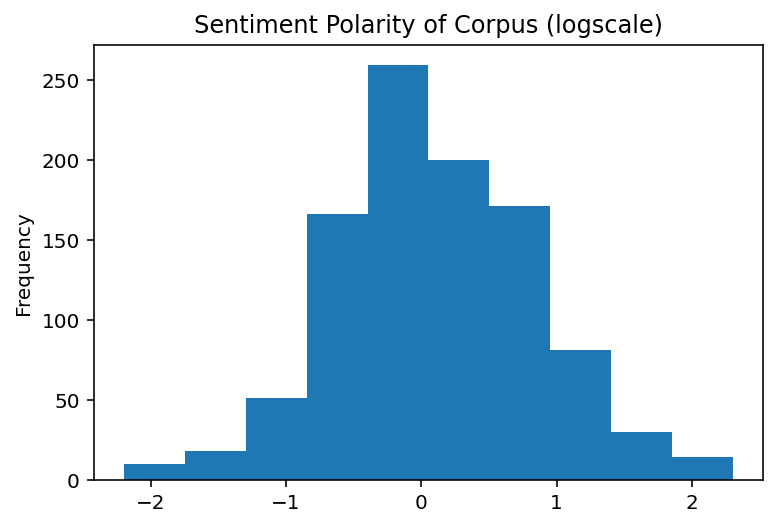

In [149]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt
df_sentiment.sentiment.plot.hist(title = 'Sentiment Polarity of Corpus (logscale)');

In [150]:
# Save results
path = Path.cwd().parent / 'data' / 'processed'
df_sentiment.to_csv(path / 'doc_sentiment.csv')